# Coherence Analyses

The notebook makes a comparison of the eigenvalue decay of coherence matrix in the case of the existence of microsiesmic events vs when there is no coherent event.

Coherence here is defined by Welch method for two signals, x and y as
$$Coherence(x,y) = \frac{|E[P_{xy}]|^2}{E[P_{xx}]E[P_{yy}]}$$

### Make imports and write functions

In [7]:
import sys

import h5py
from IPython.display import HTML, display
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from scipy.fft import ifft
import scipy.signal as ss
from sklearn.utils.extmath import randomized_svd
import time

sys.path.append('../')
import functions as f

### Parameters for data and tests

In [9]:
samples_per_sec=1000
fsize=15
nsensors=200
# start_ch = 1000
# nchannels = 3000

start_ch = 3100
nchannels = 2000
# nchannels = 5100

# start_ch = 10
# nchannels = 3000

# start_ch = 5500
# nchannels = 2500

# start_ch = 100
# nchannels = 5000

win_len = 2.5
overlap = 0

subwin_width = 4096 # number of samples in each subwindow
num_subwins = 10 # number of subwindows to average over
avgwin_width = num_subwins * subwin_width # number of samples in averaging window

colors = ['#800000', '#FFD700', '#663399', '#000000', '#008B8B']

# Background noise test

The data used in this notebook can be downloaded via the [AWS S3 Explorer for the Open Energy Data Initiative](https://data.openei.org/s3_viewer?bucket=nrel-pds-porotomo&prefix=DAS%2FH5%2FDASH%2F). The data is stored in the `nrel-pds-porotomo` bucket and the `DAS/H5/DASH/` prefix. There are separated by dates of recording and arranged in chronological order. The data is stored in the Hierarchical Data Format (HDF) and can be read using the `h5py` package. The file names end in the format `YYMMDDHHmmss.h5` where `YY` is the year, `MM` is the month, `DD` is the day, `HH` is the hour, `mm` is the minute, and `ss` is the second. 

In [10]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000018.h5"
data_noise,_= f.loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000048.h5"
data_noise2,_= f.loadBradyHShdf5(file,normalize='no')

data_noise = np.append(data_noise,data_noise2,axis=1)

In [11]:
norm_win_spectra, frequencies = f.normalised_windowed_spectra(data_noise[start_ch:nchannels+start_ch:int(nchannels/nsensors)], win_len, overlap, sample_interval=1/samples_per_sec)
welch_coherence_mat = np.matmul(norm_win_spectra, np.conjugate(norm_win_spectra.transpose(0,2,1)))
coherence = np.absolute(welch_coherence_mat)**2

# coherence, frequencies = welch_coherence(data_noise[start_ch:nchannels+start_ch:int(nchannels/nsensors)], win_len, overlap, sample_interval=1/samples_per_sec)

In [12]:
num_frames = coherence.shape[0]

eig_ratios = np.empty(num_frames)
eig_ratios_qr = np.empty(num_frames)
for d in range(num_frames):
    eigenvals, _ = np.linalg.eig(coherence[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios[d] = eigenvals[0]/np.sum(eigenvals)

    Q,R = np.linalg.qr(norm_win_spectra[d])
    qr_approx2 = np.sort(np.diag(np.absolute(R@R.transpose()))**2)[::-1]
    eig_ratios_qr[d] = qr_approx2[0]/np.sum(np.absolute(qr_approx2))

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
C:\Users\issah\AppData\Local\Temp\ipykernel_25696\2592020236.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)


Text(0.5, 1.0, 'Proportion of $\\lambda_1$ in sum of all eigenvalues')

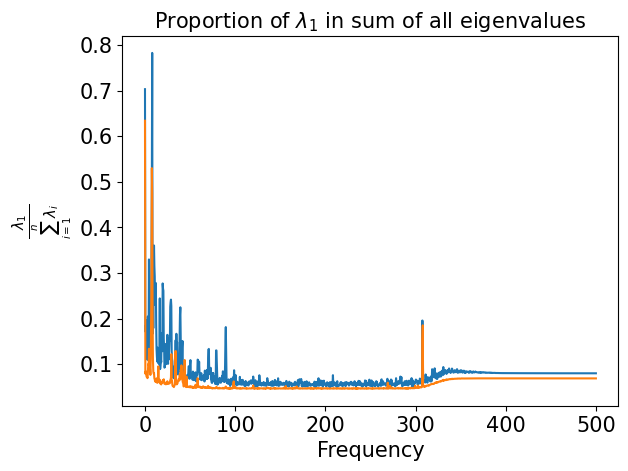

In [13]:
plt.plot(frequencies, eig_ratios_qr, label='QR')
plt.plot(frequencies, eig_ratios, label='Original')

plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)

### Plot data

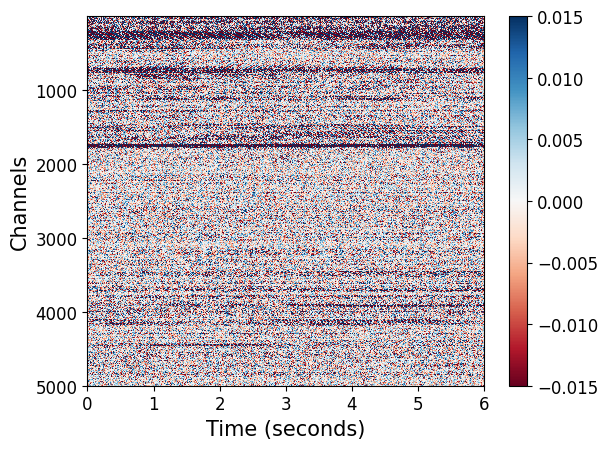

In [14]:
# pdata=np.append(data[:,24976:],data2[:,:10000],axis=1) 
# pdata=data_noise
# pdata = pdata[start_ch:nchannels+start_ch]
tick_size = 12
ch_start = 1
# v_min = -np.percentile(np.absolute(data_noise[start_ch:nchannels+start_ch]),95)
# v_max = np.percentile(np.absolute(data_noise[start_ch:nchannels+start_ch]),95)
v_min = -0.015
v_max = 0.015

# pdata = data[3000:8000, 47240:53256]

fig2 = plt.figure()
# img2 = plt.imshow(data_noise[start_ch:nchannels+start_ch], cmap="RdBu", 
img2 = plt.imshow(data_noise[3000:8000, 47240:53256], cmap="RdBu", 
           vmin=v_min, 
           vmax=v_max, aspect='auto', interpolation='none',
           extent=(0, 6, 5000, 1))
        #    extent=(0,len(data_noise[start_ch:nchannels+start_ch][0])/samples_per_sec, ch_start, ch_start + nchannels))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (seconds)',fontsize=fsize)
plt.ylabel('Channels',fontsize=fsize)
# plt.title('Background noise',fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=tick_size)

# Small event test

In [15]:
# file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314093648.h5"
# data,_ = loadBradyHShdf5(file,normalize='no')

# file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314093718.h5"
# data2,_ = loadBradyHShdf5(file,normalize='no')

# file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314093748.h5"
# data3,_= loadBradyHShdf5(file,normalize='no')

# # signalToUse=np.append(data[:,24976:],data2[:,:10000],axis=1)

# data = np.append(data,data2,axis=1)
# # data = np.append(data,data3[:,:10000],axis=1)
# data = np.append(data,data3,axis=1)
# samples_per_sec=1000

In [16]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083818.h5"
data,_ = f.loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083848.h5"
data2,_ = f.loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083918.h5"
data3,_= f.loadBradyHShdf5(file,normalize='no')

# signalToUse=np.append(data[:,24976:],data2[:,:10000],axis=1)
data = np.append(data,data2,axis=1)
data = np.append(data,data3[:,:10000],axis=1)
samples_per_sec=1000

This was an intended comparison between coherence and STA/LTA. It should be moved to a separate notebook.

In [17]:
def stalta_freq(data, len_lt, len_st):
    # Does stalta on data with len_lt as the length of the longtime and len_st
    # as the length of the short time
    if data.ndim == 1:
        longtime_avg = ss.correlate(np.absolute(data), np.ones(len_lt), mode = "valid")
        shorttime_avg = ss.correlate(np.absolute(data[(len_lt - len_st):]), np.ones(len_st), mode = "valid")
        stalta = (shorttime_avg * len_lt)/(longtime_avg * len_st)
    elif data.ndim == 2:
        nch, nsamples = data.shape
        stalta = np.empty((nch, nsamples - len_lt + 1), dtype=np.float64)
        longtime_stencil = np.ones(int(len_lt))
        shorttime_stencil = np.ones(int(len_st))
        for a in range(nch):
            longtime_avg = ss.correlate(np.absolute(data[a]), longtime_stencil, mode = "valid")
            shorttime_avg = ss.correlate(np.absolute(data[a, int(len_lt - len_st):]), shorttime_stencil, mode = "valid")
            stalta[a] = (shorttime_avg * len_lt)/(longtime_avg * len_st)

    return stalta

stalta_data = stalta_freq(data[start_ch:nchannels+start_ch:int(nchannels/nsensors)], 2000, 300)

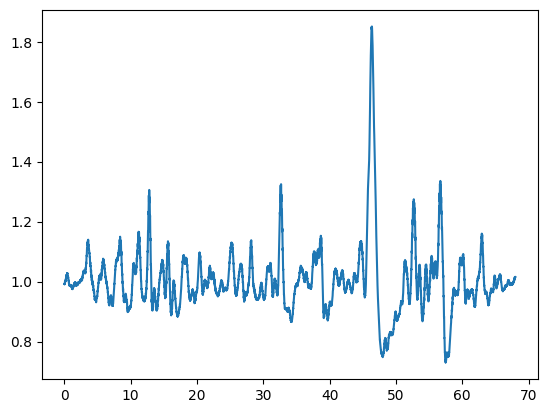

In [18]:
xax = np.array(range(stalta_data.shape[1]))/1000
plt.plot(xax, np.mean(stalta_data, axis=0))

In [7]:
t0 = time.time()
norm_win_spectra2, frequencies = f.normalised_windowed_spectra(data[start_ch:nchannels+start_ch:int(nchannels/nsensors)], win_len, overlap, sample_interval=1/samples_per_sec)
t1 = time.time()
common_time = t1-t0
welch_coherence_mat = np.matmul(norm_win_spectra2, np.conjugate(norm_win_spectra2.transpose(0,2,1)))
coherence2 = np.absolute(welch_coherence_mat)**2

# coherence2, frequencies = welch_coherence(data[start_ch:nchannels+start_ch:int(nchannels/nsensors)], win_len, overlap, sample_interval=1/samples_per_sec)

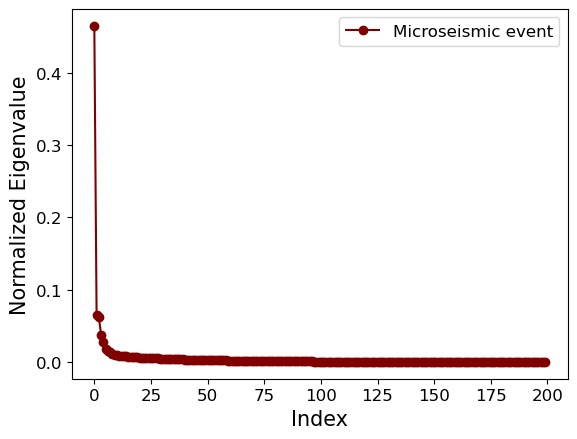

In [11]:
i = 37
tick_size = 12
# eigenvals, eigenvecs = np.linalg.eig(coherence[i])
eigenvals2, eigenvecs = np.linalg.eig(coherence2[i])
# plt.imshow(coherence[0])
# plt.colorbar()
# plt.plot(np.sort(eigenvals2/np.sum(eigenvals2))[::-1], '-o', color="darkviolet", label='Microseismic event')
# plt.plot(np.sort(eigenvals/np.sum(eigenvals))[::-1], '-*', color="goldenrod", label='Noise')

plt.plot(np.sort(eigenvals2/np.sum(eigenvals2))[::-1], '-o', color=colors[0], label='Microseismic event')
# plt.plot(np.sort(eigenvals/np.sum(eigenvals))[::-1], '-*', color=colors[1], linewidth=2, label='Noise')

# plt.yscale('log')
# plt.ylabel("Detection parameter",fontsize=fsize)
plt.ylabel("Normalized Eigenvalue",fontsize=fsize)
plt.xlabel("Index",fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
# plt.text(100, 60, 'Detection parameter = ' + str(abs(eigenvals2[0]/np.sum(eigenvals2))), color = "darkviolet", horizontalalignment='center', verticalalignment='center', fontsize=fsize)
# plt.text(100, 60, 'Detection parameter = ' + str(abs(eigenvals[0]/np.sum(eigenvals))), color = "goldenrod", horizontalalignment='center', verticalalignment='center', fontsize=fsize)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
# plt.grid(minor=True)
plt.legend(fontsize=tick_size)

# perc95 = np.percentile(eigenvals,95)

# plt.plot([0,200], [perc95,perc95])

# eigenvals = np.sort(eigenvals)[::-1]

In [12]:
num_frames = coherence2.shape[0]

eig_ratios2 = np.empty(num_frames)
eig_ratios_qr2 = np.empty(num_frames)
eig_ratios_svd2 = np.empty(num_frames)
t0 = time.time()
welch_coherence_mat = np.matmul(norm_win_spectra2, np.conjugate(norm_win_spectra2.transpose(0,2,1)))
coherence2 = np.absolute(welch_coherence_mat)**2
for d in range(num_frames):
    eigenvals, _ = np.linalg.eig(coherence2[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios2[d] = eigenvals[0]/np.sum(eigenvals)
t1 = time.time()
eig_time = t1-t0 + common_time

t0 = time.time()
for d in range(num_frames):
    Q,R = np.linalg.qr(norm_win_spectra2[d])
    qr_approx2 = np.sort(np.diag(np.absolute(R@R.transpose()))**2)[::-1]
    eig_ratios_qr2[d] = qr_approx2[0]/np.sum(np.absolute(qr_approx2))
t1 = time.time()
qr_time = t1-t0 + common_time


t0 = time.time()
for d in range(num_frames):
    U, S, Vh = np.linalg.svd(norm_win_spectra2[d])
    svd_approx2 = np.sort(S)[::-1]**2
    eig_ratios_svd2[d] = svd_approx2[0]/np.sum(np.absolute(svd_approx2))
t1 = time.time()
svd_time = t1-t0 + common_time


print("Eigenvalue time: ", eig_time)
print("QR time: ", qr_time)
print("SVD time: ", svd_time)

Eigenvalue time:  91.70383524894714
QR time:  2.4749300479888916
SVD time:  13.184210538864136


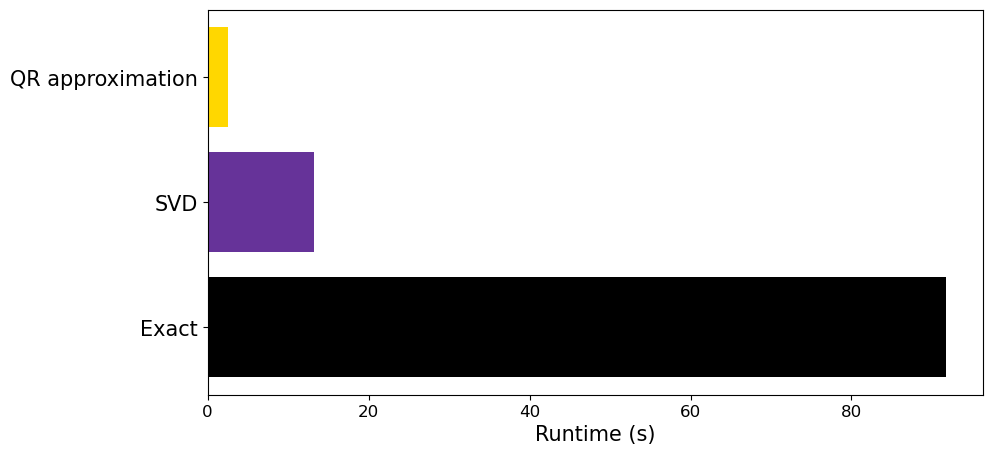

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

methods = ["Exact", "SVD", "QR approximation"]
# methods = [1, 1.2]
times = [eig_time, svd_time, qr_time]
bar_labels = ["Exact", "SVD", "QR approximation"]
# bar_colors = ['darkviolet', 'goldenrod']
# bar_colors = ['#800000', '#FFD700'] #'#FFA500']
bar_colors = [colors[3], colors[2], colors[1]]
# bar_colors = colors[2:4][::-1]

ax.barh(methods, times, label=bar_labels, color=bar_colors, height=0.8)

ax.set_xlabel('Runtime (s)', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=fsize)
# ax.set_title('Runtime')
# ax.legend(fontsize=tick_size)

plt.show()

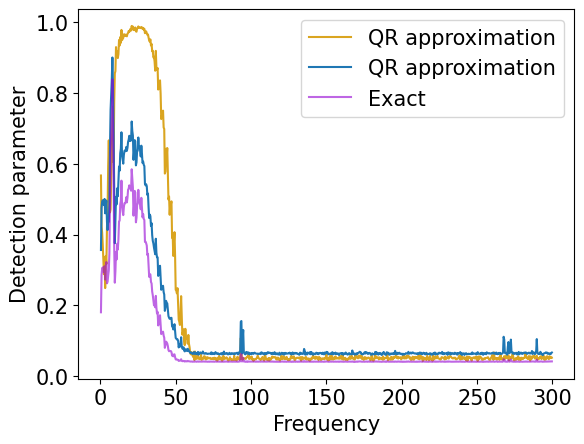

In [16]:
last_freq_index = 750

plt.plot(frequencies[1:last_freq_index], eig_ratios_qr2[1:last_freq_index], color="goldenrod", label='QR approximation')
plt.plot(frequencies[1:last_freq_index], eig_ratios_svd2[1:last_freq_index], label='SVD approximation')
plt.plot(frequencies[1:last_freq_index], eig_ratios2[1:last_freq_index], color="darkviolet", alpha=0.6, label='Exact')
# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.legend(fontsize=fsize)

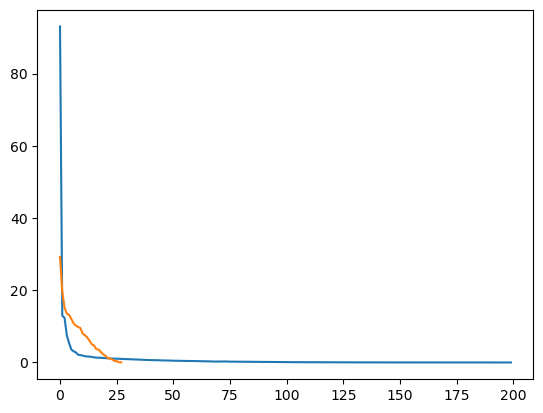

In [17]:
plt.plot(eigenvals2)
plt.plot(svd_approx2)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0')])

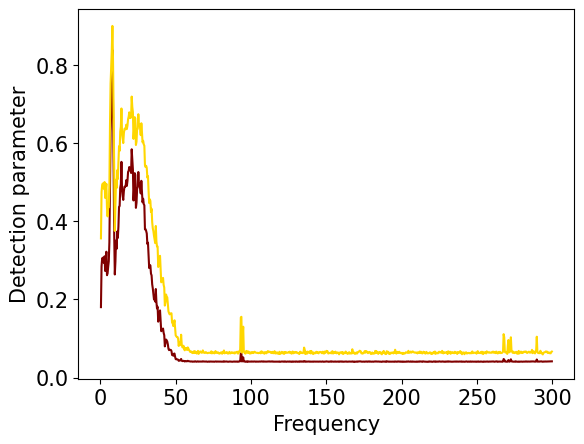

In [19]:
plt.plot(frequencies[1:last_freq_index], eig_ratios2[1:last_freq_index], color=colors[0], label="Microseismic Event")
plt.plot(frequencies[1:last_freq_index], eig_ratios_svd2[1:last_freq_index], color=colors[1], label="Noise")
# plt.plot(frequencies[1:last_freq_index], eig_ratios[1:last_freq_index], color=colors[0], label="Noise")
plt.ylabel("Detection parameter",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
# plt.legend(fontsize=fsize)

$$\text{Detection parameter} = \frac{\lambda_i}{\sum_{i=1}^{n}{\lambda_i}}$$

NameError: name 'eig_ratios' is not defined

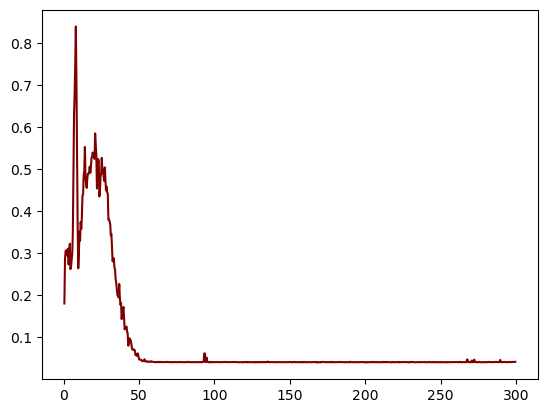

In [20]:
last_freq_index = 750
tick_size = 12
plt.plot(frequencies[1:last_freq_index], eig_ratios2[1:last_freq_index], color=colors[0], label="Microseismic Event")
plt.plot(frequencies[1:last_freq_index], eig_ratios[1:last_freq_index], color=colors[-1], alpha=0.9 , label="Background Noise")

# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
# plt.grid(minor=True)
plt.legend(fontsize=tick_size)

In [ ]:
last_freq_index = 750
tick_size = 12
plt.plot(frequencies[1:last_freq_index], eig_ratios_qr[1:last_freq_index], color="goldenrod", label="Background Noise")
plt.plot(frequencies[1:last_freq_index], eig_ratios_qr2[1:last_freq_index], color="darkviolet", alpha=0.5 , label="Microseismic Event")
# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
# plt.grid(minor=True)
plt.legend(fontsize=tick_size)

: 

In [ ]:

avg_eigs = np.mean(eig_ratios[1:].reshape((125,10)), axis=1)
avg_eigs2 = np.mean(eig_ratios2[1:].reshape((125,10)), axis=1)
avg_freq = np.linspace(1,499,125)

plt.plot(avg_freq, avg_eigs, label="background noise")
plt.plot(avg_freq, avg_eigs2, label="microsiesmic event")

# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.legend(fontsize=tick_size)


: 

### Plot data

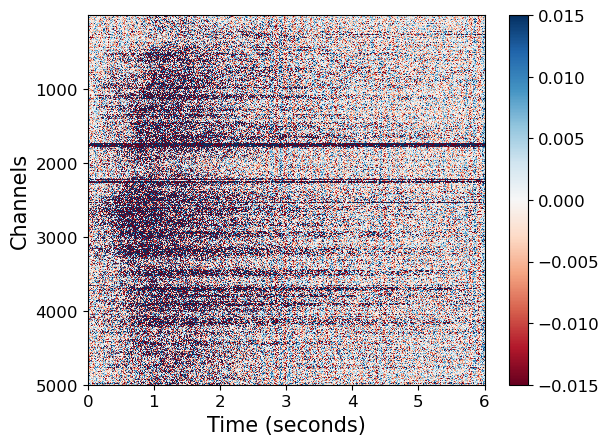

In [115]:
fsize=15
tick_size = 12
ch_start = 1
# pdata = data[start_ch:nchannels+start_ch, 47000:54000]
# pdata = data[start_ch+int(nchannels/2):nchannels*2+start_ch, 47000:53000]
pdata = data[3000:8000, 47240:53256]
# templateSamples=[17240, 23256]

# v_min = -np.percentile(np.absolute(pdata),95)
# v_max = np.percentile(np.absolute(pdata),95)
v_min = -0.015
v_max = 0.015

fig2 = plt.figure()
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=v_min, 
           vmax=v_max, aspect='auto', interpolation='none',
           extent=(0,6, 5000, 1))
         #   extent=(0,len(pdata[0])/samples_per_sec, ch_start, ch_start + nchannels))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (seconds)',fontsize=fsize)
plt.ylabel('Channels',fontsize=fsize)
# plt.title('Signal',fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=tick_size)

([], [])

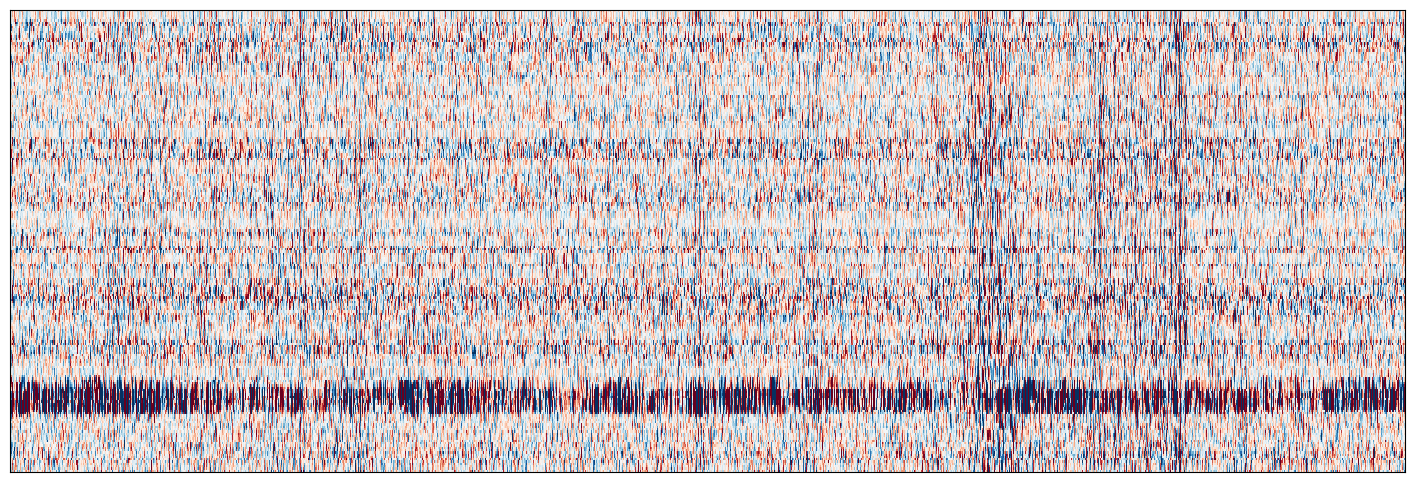

In [70]:
# plt.figure(figsize=(6,12))
fsize=15
tick_size = 12
ch_start = 1
# pdata = data[start_ch:nchannels+start_ch]
pdata = data[start_ch:200+start_ch]

# v_min = -np.percentile(np.absolute(pdata),95)
# v_max = np.percentile(np.absolute(pdata),95)
v_min = -0.015
v_max = 0.015

fig2 = plt.figure(figsize=(18,6))
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=v_min, 
           vmax=v_max, aspect='auto', interpolation='none')
        #    extent=(0,len(pdata[0])/samples_per_sec, ch_start, ch_start + nchannels))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))

# plt.xlabel('Time (seconds)',fontsize=fsize)
# plt.ylabel('Sensors',fontsize=fsize)
# plt.title('Signal',fontsize=fsize)
plt.xticks([])
tick_loc = 2500
# plt.plot([tick_loc, tick_loc], [0, 200], linewidth=3)
plt.yticks([])
# cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=tick_size)

# for a in range(1, int(len(data[1])/(win_len * samples_per_sec))):
#     tick_loc = a *  win_len * samples_per_sec
#     plt.plot([tick_loc, tick_loc], [0, 200], 'r', linewidth=3)

In [59]:
len(data[1])/(2.5 * samples_per_sec)

28.0

In [78]:
frequencies[190]

76.0

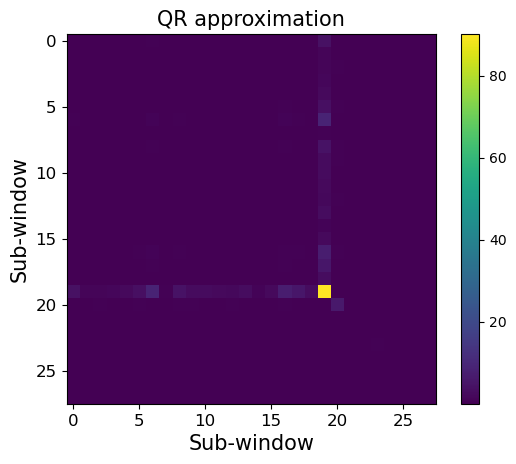

In [91]:
RandA = norm_win_spectra2[39,:,:]**2
Q1,R1 = np.linalg.qr(RandA)
plt.imshow(np.abs(R1@R1.T))
plt.ylabel('Sub-window', fontsize=fsize)
plt.xlabel('Sub-window', fontsize=fsize)
plt.title('QR approximation', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.colorbar()
# plt.subplot(1,3,3)

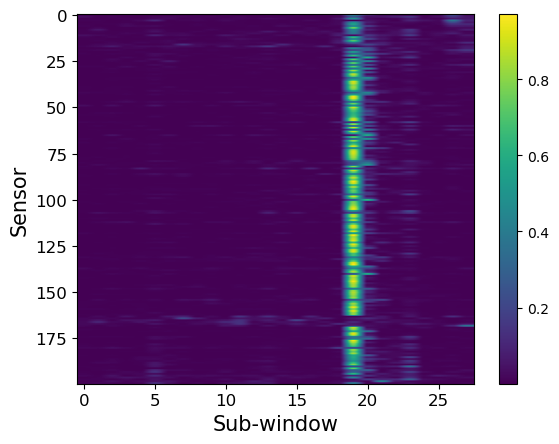

In [92]:
plt.imshow(np.abs(RandA), aspect='auto')
plt.ylabel('Sensor', fontsize=fsize)
plt.xlabel('Sub-window', fontsize=fsize)
# plt.title('QR approximation', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.colorbar()

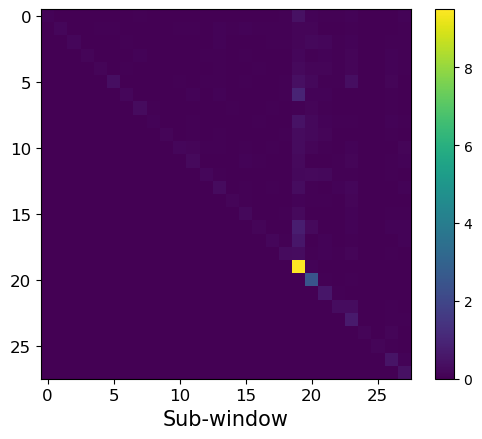

In [93]:
# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
plt.imshow(np.abs(R1))
# plt.title('R Matrix', fontsize=15)
# plt.ylabel('Sub-window', fontsize=fsize)
plt.xlabel('Sub-window', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.colorbar()
# plt.subplot(1,2,2)
# plt.plot(frequencies)


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0')])

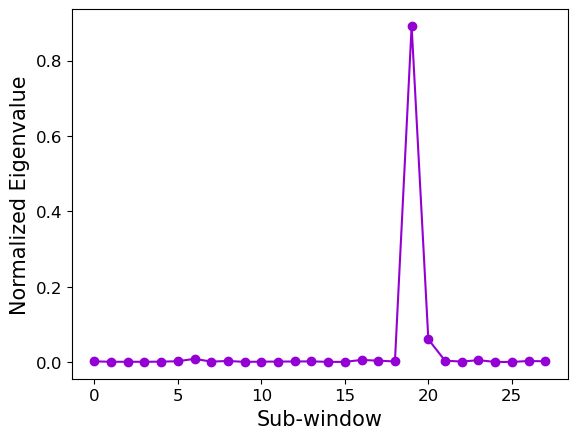

In [94]:
qr_ = np.diag(np.absolute(R1@R1.transpose()))
plt.plot(qr_/np.sum(qr_), '-o', color="darkviolet")
plt.ylabel('Normalized Eigenvalue', fontsize=fsize)
plt.xlabel('Sub-window', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
# plt.title('QR Approximation of Eigenvalues', fontsize=15)
# print(np.max(qr_)/np.sum(np.absolute(qr_)))

In [ ]:
AA = 0
for a in range(1,101):
    AA += round(1/a,2)
    AA = round(AA,2)
    if round(1/a,2) > 1/a:
        AA -= 0.01
    # print(AA)
AA

4.82

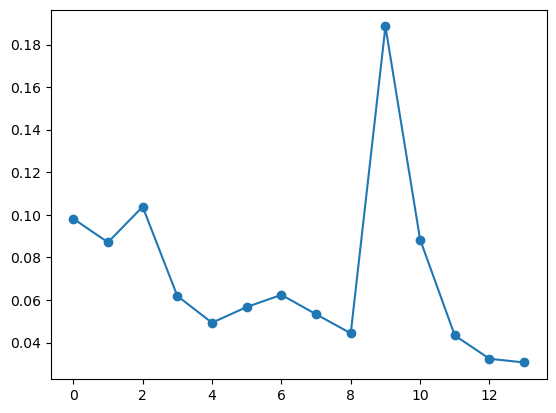

In [ ]:
# plt.plot(np.abs(R1)[9], '-o')
# plt.plot(np.abs(R1@R1.T)[9], '-o')
# R1[-1]
appr = np.sum(np.abs(R1), axis=1)
plt.plot(appr/np.sum(appr), '-o')
